In [17]:
import os
import numpy as np
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyproj import Geod


# Data Import

In [2]:
def dataconcat (dir_path): # path of the folder containing the netCDF files 
    all_files = glob.glob(os.path.join(dir_path, "*.nc")) 
    
    groups = defaultdict(list) 
    for fp in all_files: 
        fname = os.path.basename(fp) 
        model_name = fname.split("_")[2] 
        groups[model_name].append(fp) 
        datasets = {}

    for prefix, files in groups.items(): 
        files = sorted(files) 
        print(f"Concatenating {len(files)} files for {prefix}") 
        ds = xr.open_mfdataset( files, combine="by_coords", parallel=True ) 
        datasets[prefix] = ds.isel(time=slice(-20 * 12, None)) 
    
    return datasets 
              
sst_datasets = dataconcat("/glade/work/stevenxu/AMOC_models/sea_surface_temperature/scenarios/PIControl") 
sss_datasets = dataconcat("/glade/work/stevenxu/AMOC_models/sea_surface_salinity/scenarios/PIControl") 
hf_datasets = dataconcat("/glade/work/stevenxu/AMOC_models/heatflux/scenarios/PIControl") 
wf_datasets = dataconcat("/glade/work/stevenxu/AMOC_models/waterflux/scenarios/PIControl")

Concatenating 1 files for ACCESS-CM2


/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cft

Concatenating 1 files for ACCESS-CM2


/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cft

Concatenating 1 files for ACCESS-CM2


/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cft

Concatenating 1 files for ACCESS-CM2


/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/coding/times.py:170: SerializationWarning: Ambiguous reference date string: 950-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0950-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/stevenxu/conda-envs/amoc-env/lib/python3.11/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cft

In [ ]:
sst_datasets["ACCESS-CM2"]

<xarray.DataArray 'vertices_latitude' (j: 300, i: 360, vertices: 4)> Size: 3MB
dask.array<open_dataset-vertices_latitude, shape=(300, 360, 4), dtype=float64, chunksize=(300, 360, 2), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude  (j, i) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: vertices
Attributes:
    units:    degrees_north

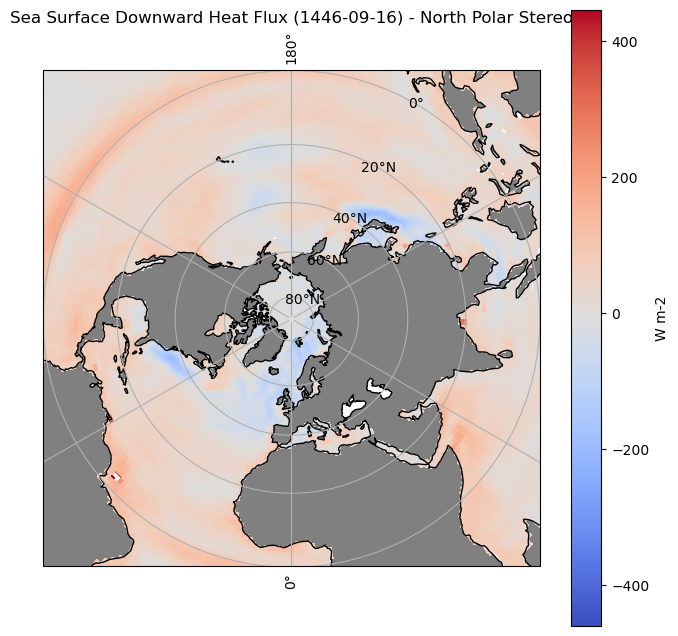

In [4]:
ds = hf_datasets["ACCESS-CM2"]
da = ds['hfds'].isel(time=200)
da = da.where(da < 480)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.add_feature(cfeature.LAND, facecolor='gray', zorder=0)

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
pcm = ax.pcolormesh(
    ds['longitude'], ds['latitude'], da,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm'
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label=da.units)
plt.title(f"Sea Surface Downward Heat Flux ({str(ds['time'].values[200])[:10]}) - North Polar Stereo")
plt.show()

# Calculate sea surface density

In [19]:
def compute_surface_density(model, sst_datasets, sss_datasets, last_n_months=None):
    T  = sst_datasets[model]['tos']          
    SP = sss_datasets[model]['sos']          
    lon = sst_datasets[model]['longitude']
    lat = sst_datasets[model]['latitude']
    # addubg vertices for accurate area-weighted calculations for next step
    vertices_latitude = sst_datasets[model]['vertices_latitude']
    vertices_longitude = sst_datasets[model]['vertices_longitude']

    p0 = 0.0

    if last_n_months is not None:
        T  = T.isel(time=slice(-last_n_months, None))
        SP = SP.isel(time=slice(-last_n_months, None))

    """SA = xr.apply_ufunc(
        gsw.SA_from_SP, SP, p0, lon, lat,
        dask='parallelized', vectorize=True, output_dtypes=[float]
    )
    CT = xr.apply_ufunc(
        gsw.CT_from_t, SA, T, p0,
        dask='parallelized', vectorize=True, output_dtypes=[float]
    )"""
    alpha = xr.apply_ufunc(
        gsw.density.alpha, SP, T, p0,
        dask='parallelized', output_dtypes=[float]
    )
    beta = xr.apply_ufunc(
        gsw.density.beta, SP, T, p0,
        dask='parallelized', output_dtypes=[float]
    )
    rho = xr.apply_ufunc(
        gsw.density.rho, SP, T, p0,
        dask='parallelized', vectorize=True, output_dtypes=[float]
    )

    rho  = rho.rename('rho').assign_attrs(units='kg m-3',  long_name='Sea-surface density')
    alpha  = alpha.rename('alpha')
    beta  = beta.rename('beta')



    return xr.Dataset(dict(rho=rho, alpha=alpha, beta=beta, vertices_latitude=vertices_latitude, vertices_longitude=vertices_longitude))

surf_den_ACCESS = compute_surface_density("ACCESS-CM2", sst_datasets, sss_datasets, last_n_months=240)
surf_den_ACCESS

<xarray.Dataset> Size: 631MB
Dimensions:             (time: 240, j: 300, i: 360, vertices: 4)
Coordinates:
  * time                (time) object 2kB 1430-01-16 12:00:00 ... 1449-12-16 ...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 864kB -77.88 -77.88 ... 65.63 65.21
    longitude           (j, i) float64 864kB 80.5 81.5 82.5 ... 79.97 79.99
Dimensions without coordinates: vertices
Data variables:
    rho                 (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    alpha               (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    beta                (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>

# Plotting Sea Surface Density

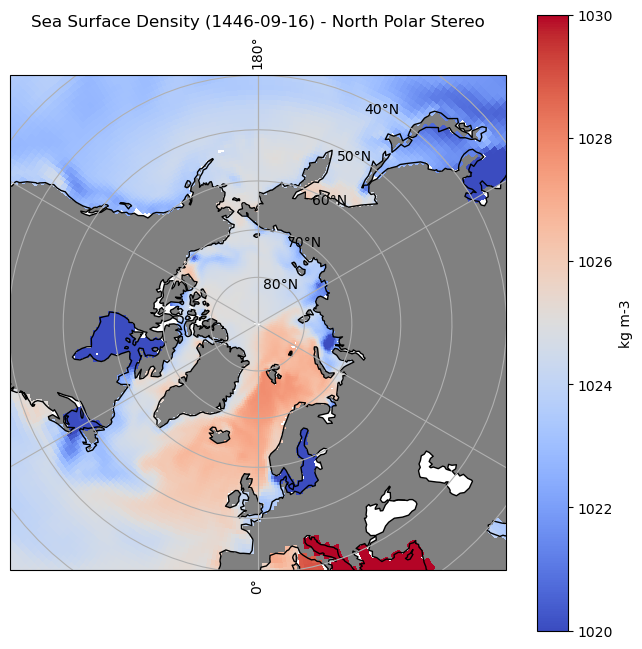

In [270]:
ds = surf_den_ACCESS
da = ds['rho'].isel(time=200)
#da = da.where(da > 1020)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.add_feature(cfeature.LAND, facecolor='gray', zorder=0)

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
pcm = ax.pcolormesh(
    ds['longitude'], ds['latitude'], da,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    vmin=1020, 
    vmax=1030  
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label=da.units)
plt.title(f"Sea Surface Density ({str(ds['time'].values[200])[:10]}) - North Polar Stereo")
plt.show()

# Calculate F surf

In [22]:
def compute_fsurf(model,
                  sst_datasets, sss_datasets, hf_datasets, wf_datasets,
                  cp=3990.0, rho0=1027.0, rho_fw=1000.0, S0=35.0,
                  last_n_months=None):

    HF = hf_datasets[model]['hfds']  # W m^-2, 
    WF = wf_datasets[model]['wfo']     # kg m^-2 s^-1, 
    lon = sst_datasets[model]['longitude']
    lat = sst_datasets[model]['latitude']
    p0 = 0.0
    # addubg vertices for accurate area-weighted calculations for next step
    vertices_latitude = sst_datasets[model]['vertices_latitude']
    vertices_longitude = sst_datasets[model]['vertices_longitude']

    density_data = compute_surface_density(model, sst_datasets, sss_datasets, last_n_months=last_n_months)
    rho = density_data['rho']
    alpha = density_data['alpha']
    beta = density_data['beta']

    if last_n_months is not None:
        HF  = HF.isel(time=slice(-last_n_months, None))
        WF = WF.isel(time=slice(-last_n_months, None))

    # f_surf = -(alpha/cp) * f_heat  - (rho0/rho_fw) * beta * S0 * f_water
    fsurf = -(alpha / cp) * HF  -  (rho0 / rho_fw) * beta * S0 * WF
    fsurf = fsurf.assign_attrs(
        long_name="Buoyancy-relevant surface forcing (Eq. 5)",
        description="-(alpha/cp)*f_heat - (rho0/rho_fw)*beta*S0*f_water",
        units="",
        cp=cp, rho0=rho0, rho_fw=rho_fw, S0=S0
    )

    heat_comp = -(alpha / cp) * HF
    fw_comp = -(rho0 / rho_fw) * beta * S0 * WF

    return xr.Dataset(dict(fsurf=fsurf, rho=rho, heat_comp=heat_comp, fw_comp=fw_comp, vertices_latitude=vertices_latitude, vertices_longitude=vertices_longitude))

out_ACCESS = compute_fsurf(
    "ACCESS-CM2",
    sst_datasets=sst_datasets,
    sss_datasets=sss_datasets,
    hf_datasets=hf_datasets,
    wf_datasets=wf_datasets,
    last_n_months=240
)

out_ACCESS

<xarray.Dataset> Size: 838MB
Dimensions:             (time: 240, j: 300, i: 360, vertices: 4)
Coordinates:
  * time                (time) object 2kB 1430-01-16 12:00:00 ... 1449-12-16 ...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 864kB -77.88 -77.88 ... 65.63 65.21
    longitude           (j, i) float64 864kB 80.5 81.5 82.5 ... 79.97 79.99
Dimensions without coordinates: vertices
Data variables:
    fsurf               (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    rho                 (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    heat_comp           (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fw_comp             (time, j, i) float64 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>

# Plotting F surf

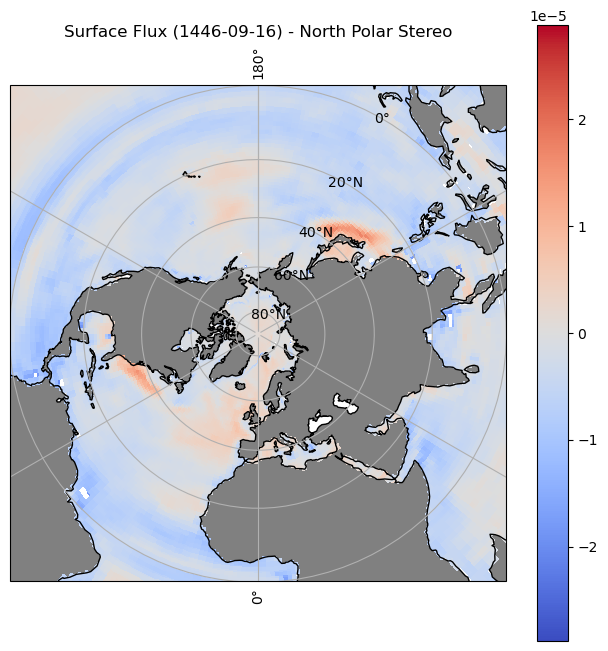

In [ ]:
ds = out_ACCESS
da = ds['fsurf'].isel(time=200)
da = da.where(da > -0.00002)  # filter out the abnormal values

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax.add_feature(cfeature.LAND, facecolor='gray', zorder=0)

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-180, 180, 0, 30], crs=ccrs.PlateCarree())

v = np.nanmax(np.abs(da.values))
pcm = ax.pcolormesh(
    ds['longitude'], ds['latitude'], da,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    vmin=-v, vmax=v
)
plt.colorbar(pcm, ax=ax, orientation='vertical', label=da.units)
plt.title(f"Surface Flux ({str(ds['time'].values[200])[:10]}) - North Polar Stereo")
plt.show()

# Calculating Fgen at single timepoint

### Create density class list
Take max and min in rho values, and slice with interval 0.01

In [ ]:
ds = out_ACCESS
da = ds['rho'].isel(time=0)
rho_min = float(da.min())
rho_max = float(da.max())

In [205]:
step_size = 0.1
rho_classes = np.arange(rho_min, rho_max + step_size, step_size)

### Generating i,j coordinate index for area at each grid cell
area[i,j] gives the area at coordinate i,j

In [190]:
geod = Geod(ellps="WGS84")
latv = out_ACCESS["vertices_latitude"]
lonv = out_ACCESS["vertices_longitude"]

def cell_area(lons, lats):
    area = geod.polygon_area_perimeter(lons, lats)[0]
    return np.abs(area)

area = xr.apply_ufunc(
    cell_area,
    lonv, latv,
    input_core_dims=[["vertices"], ["vertices"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
    dask_gufunc_kwargs={"allow_rechunk": True},
)
area = area.compute().to_numpy()
# area [j,1]

### Integration

Group by intervals and adding up the area-weighted fsurf

In [393]:
fsurf = out_ACCESS["fsurf"].isel(time=slice(200,202))     
rho   = out_ACCESS["rho"].isel(time=slice(200,202)) 

# latitude filtering
mask = (out_ACCESS["latitude"] > 30)
j_idx, i_idx = np.nonzero(mask.compute().to_numpy())  

# apply filtered indexes
weighted_fsurf = fsurf * area
weighted_fsurf = weighted_fsurf.isel(
    j=xr.DataArray(j_idx, dims="points"),
    i=xr.DataArray(i_idx, dims="points")
)
weighted_fsurf

rho = rho.isel(
    j=xr.DataArray(j_idx, dims="points"),
    i=xr.DataArray(i_idx, dims="points")
)

In [394]:
Fgen_org = weighted_fsurf.groupby_bins(rho, bins=rho_classes, right=False).sum(dim="points") / step_size /1e6
Fgen_org

<xarray.DataArray 'fsurf' (rho_bins: 363, time: 2)> Size: 6kB
dask.array<truediv, shape=(363, 2), dtype=float64, chunksize=(363, 1), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 16B 1446-09-16 00:00:00 1446-10-16 12:00:00
  * rho_bins  (rho_bins) int64 3kB 0 1 2 3 4 5 6 ... 356 357 358 359 360 361 362

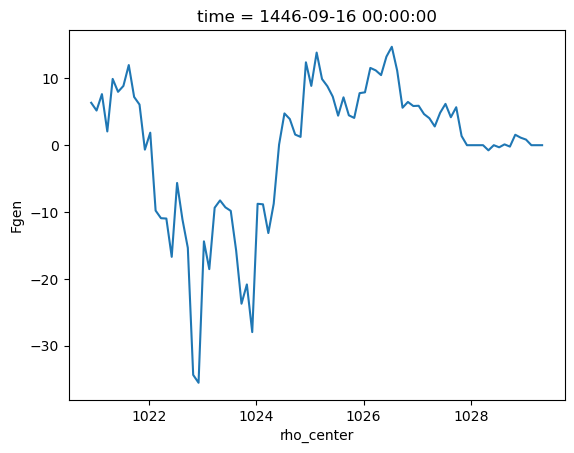

In [397]:
rho_centers = (rho_classes[:-1] + rho_classes[1:]) / 2
Fgen = Fgen_org.assign_coords(rho_center=("rho_bins", rho_centers))
Fgen = Fgen.rename(rho_bins="rho_intervals")
Fgen = Fgen.rename('Fgen')
Fgen.isel(time=0, rho_intervals= slice(175,260)).plot(x = 'rho_center')